In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from textblob import TextBlob
import json

In [99]:
#Read the files
normal_reviews = pd.read_csv('relevant_reviews.csv')
not_recommended = pd.read_csv('not-recommended-reviews.csv')

In [100]:
#Drop review id, 'useful', 'funny', 'cool. I dont think we need it.
normal_reviews = normal_reviews.drop(['review_id','useful','funny','cool'], axis=1)

In [101]:
#DATE FORMAT IN THE TWO DATAFRAME IS DIFFERENT, I FIX IT HERE.
normal_reviews['date'] = pd.to_datetime(normal_reviews['date'])

not_recommended['review_date'] = not_recommended['review_date'].str.split('\n').str[0]
not_recommended['review_date'] = pd.to_datetime(not_recommended['review_date'], format='%d.%m.%Y', errors='coerce')

In [102]:
count_restaunrat = len(normal_reviews['business_id'].value_counts(dropna=False))
print(f'there are {count_restaunrat} businesses in the dataset')

there are 505 businesses in the dataset


In [103]:
normal_reviews.head(5)

,user_id,business_id,stars,text,date
0,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14
1,9oHOoqk-HlwDS2DlHLi_0g,TttFjRQ-8Iz8by4hsD7iOQ,5,Last night we tried to get into the oldest Ita...,2017-11-06 17:26:43
2,gSEhdaQNcewg-ob6xSgleQ,1NCUTTp6rIyXpwUDVv9qOA,2,I had to write an order after coming here a co...,2016-06-22 21:51:03
3,JW5W4OZCohTvZlRF1jzrTg,u7_3L1NBWgxhBM_B-cmmnA,4,This amazing brick oven pizza joint gets bette...,2017-04-30 15:00:27
4,7ktyPHE-NGnWxarOqjIQiQ,CinrOH8rMB2hEvPY_iFOHA,1,"I really wanted to like Casselli's, but it was...",2009-03-02 02:05:49


In [104]:
not_recommended.head(5) # need to remove Sterne in rating (string to int)

,business_id,user_name,user_location,has_image,friends_count,reviews_count,photos_count,rating,review_date,language,review_text
0,QdN72BWoyFypdGJhhI5r7g,C C.,"Philadelphia, Vereinigte Staaten",False,0,1,0,1.0 Sterne,2016-11-06,en,"Totally dissapionted and a big boo!, Maybe the..."
1,QdN72BWoyFypdGJhhI5r7g,Edward M.,"Philadelphia, Vereinigte Staaten",False,0,13,0,2.0 Sterne,2019-06-30,en,Pros: good food. Decent drinks. Nice neighborh...
2,QdN72BWoyFypdGJhhI5r7g,Isabel W.,"Mercer Island, Vereinigte Staaten",False,65,59,1 Foto,3.0 Sterne,2019-06-02,en,"Good, honey bar, but it hardly ever has dark b..."
3,QdN72BWoyFypdGJhhI5r7g,Katherine T.,"Camden County, Vereinigte Staaten",False,308,3,0,5.0 Sterne,2019-07-12,en,Phenomenal customer service. Jules is amazing....
4,QdN72BWoyFypdGJhhI5r7g,Jay M.,"Millstone, Vereinigte Staaten",True,187,2,0,5.0 Sterne,2017-02-09,en,"Great food, great service. Best happy hour aro..."


In [105]:
#select a cut_off date
cut_off_date = pd.to_datetime("2013-11-14")

In [111]:
#Get total number of not recommended reviews PRE CUTOFF DATE --> #3316
count_not_rec_reviews_pre = len(not_recommended[not_recommended['review_date'] < cut_off_date])

#Get total number of not recommended reviews POST CUTOFF DATE --> #6367
count_not_rec_reviews_after = len(not_recommended[not_recommended['review_date'] >= cut_off_date])

print(f'There is are a total of {len(not_recommended)} not recommended reviews')
print(f"Total not recommended reviews PRE CUTOFF DATE: {count_not_rec_reviews_pre}, POST CUTOFF DATE: {count_not_rec_reviews_after}")

There is are a total of 9683 not recommended reviews
Total not recommended reviews PRE CUTOFF DATE: 3316, POST CUTOFF DATE: 6367


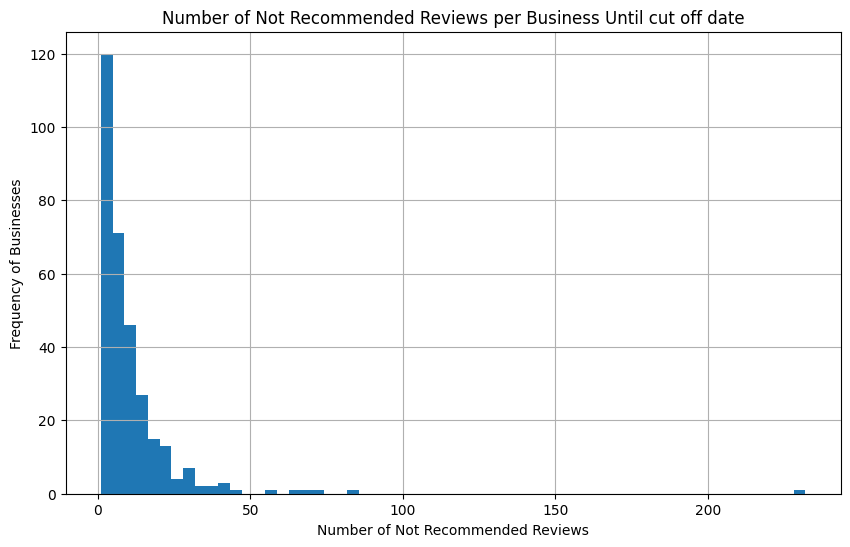

In [144]:
#Create one single data frame with business_id; num not recommended UNTILL cut off
#Check below for the one about normal reviews

not_recommended_pre_cutoff = not_recommended[not_recommended['review_date'] < cut_off_date]
not_recommended_agg_pre_cutoff = not_recommended_pre_cutoff.groupby('business_id')['business_id'].count()
not_recommended_agg_pre_cutoff = not_recommended_agg_pre_cutoff.reset_index(name='not_recommended_review_count_pre') #or index problems later


plt.figure(figsize=(10, 6))
not_recommended_agg_pre_cutoff['not_recommended_review_count_pre'].hist(bins=60)
plt.title('Number of Not Recommended Reviews per Business Until cut off date')
plt.xlabel('Number of Not Recommended Reviews')
plt.ylabel('Frequency of Businesses')
plt.show()

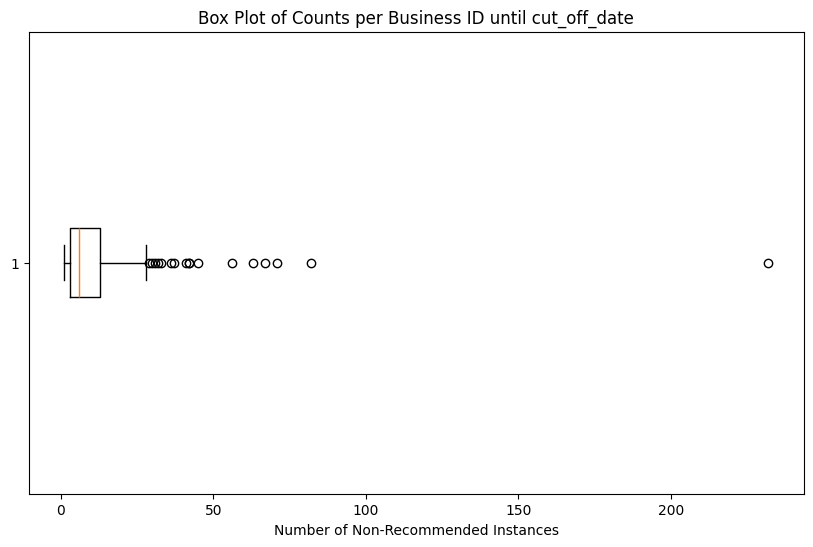

In [145]:
plt.figure(figsize=(10, 6))
plt.boxplot(not_recommended_agg_pre_cutoff['not_recommended_review_count_pre'], vert=False)
plt.title('Box Plot of Counts per Business ID until cut_off_date')
plt.xlabel('Number of Non-Recommended Instances')
plt.show()

In [146]:
#not_recommended_agg_pre_cutoff[not_recommended_agg_pre_cutoff['not_recommended_review_count_pre'].isna()]

q1_not_rec = not_recommended_agg_pre_cutoff['not_recommended_review_count_pre'].quantile(0.25) 
q4_not_rec = not_recommended_agg_pre_cutoff['not_recommended_review_count_pre'].quantile(0.75) 

print(f'ONLY PRE-CUT-OFF-DATE: Q1 is {int(q1_not_rec)} AND q4 is {int(q4_not_rec)}')

ONLY PRE-CUT-OFF-DATE: Q1 is 3 AND q4 is 13


Text(0, 0.5, 'Frequency')

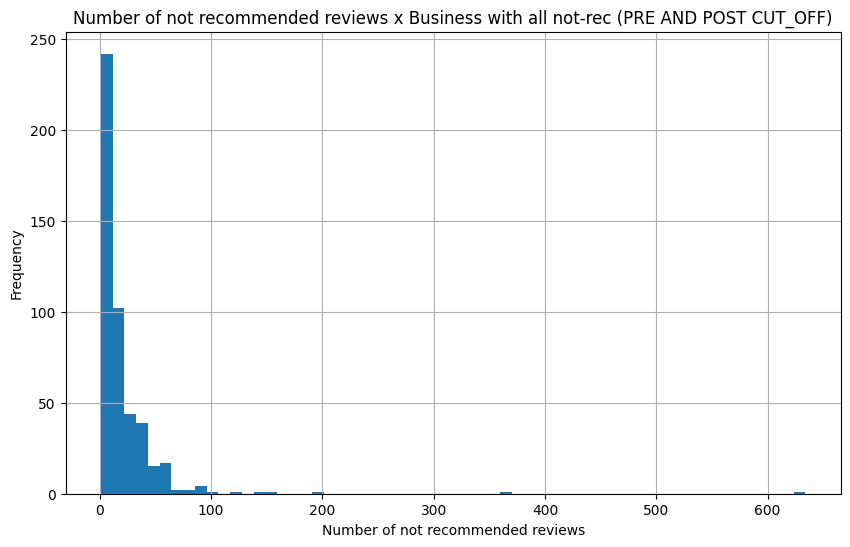

In [148]:
#Create one single data frame with business_id; num not recommended (ALL NOT REC-REVIEWS)
not_recommended_all_grouped = not_recommended.groupby('business_id')['business_id'].count()

plt.figure(figsize=(10, 6))
not_recommended_all_grouped.hist(bins=60) 
plt.title('Number of not recommended reviews x Business with all not-rec (PRE AND POST CUT_OFF)')
plt.xlabel('Number of not recommended reviews')
plt.ylabel('Frequency')

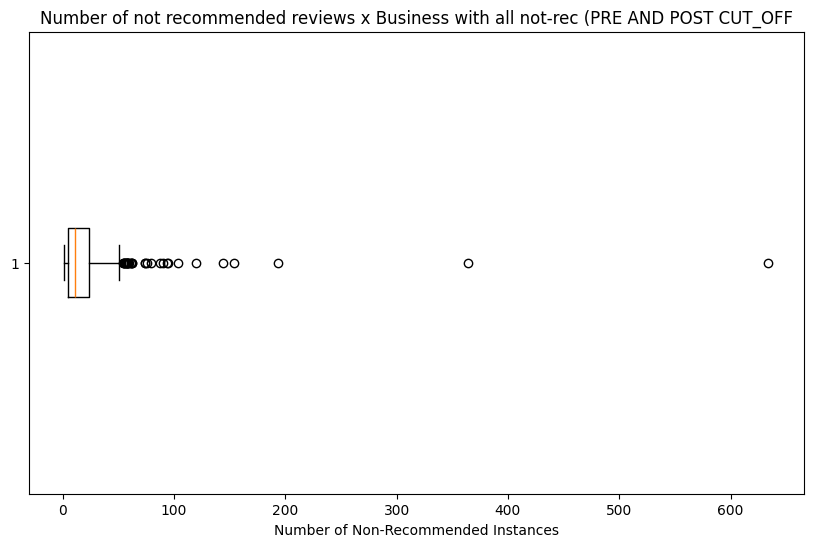

In [149]:
plt.figure(figsize=(10, 6))
plt.boxplot(not_recommended_all_grouped, vert=False) 
plt.title('Number of not recommended reviews x Business with all not-rec (PRE AND POST CUT_OFF')
plt.xlabel('Number of Non-Recommended Instances')
plt.show()

In [86]:
q1_not_rec_all = not_recommended_all_grouped.quantile(0.25) 
q4_not_rec_all = not_recommended_all_grouped.quantile(0.75) 

print(f'ONLY PRE-CUT-OFF-DATE: Q1 is {q1_not_rec_all} AND q4 is {q4_not_rec_all}')

ONLY PRE-CUT-OFF-DATE: Q1 is 5.0 AND q4 is 24.0


In [140]:
time_delta = pd.Timedelta(weeks=8)

start_date = cut_off_date - time_delta
end_date = cut_off_date + time_delta

reviews_cutoff_minus_delta = normal_reviews[(normal_reviews['date'] >= start_date) & (normal_reviews['date'] < cut_off_date)]
reviews_cutoff_plus_delta = normal_reviews[(normal_reviews['date'] >= cut_off_date) & (normal_reviews['date'] <= end_date)]

combined_reviews = pd.concat([reviews_cutoff_minus_delta, reviews_cutoff_plus_delta])


total_reviews_cutoff_minus_delta = len(reviews_cutoff_minus_delta)
total_reviews_cutoff_plus_delta = len(reviews_cutoff_plus_delta)

print(f'There is a total of {len(combined_reviews)}')
print(f"Total reviews within two weeks before cutoff: {total_reviews_cutoff_minus_delta}, Total reviews within two weeks after cutoff: {total_reviews_cutoff_plus_delta}")


There is a total of 2152
Total reviews within two weeks before cutoff: 1118, Total reviews within two weeks after cutoff: 1034


,user_id,business_id,stars,text,date
28,Yr7tRi9b5-Na2FWP5ihG2A,BWITd9JUXP3gSi1z3Y-z8g,4,Amazing pizza. Also love ceci bean dip. Great ...,2013-10-24 02:21:23
33,X9jjZ93FFoVEo6lqy6CAGw,L2pmVQMrpY-yZwZkZoRt5g,1,Over priced . Every time I go there the owner ...,2013-10-03 17:03:48
68,70SYLsz1p8K7dYU6koZ7Kg,1NCUTTp6rIyXpwUDVv9qOA,4,"Tried the cheesesteak, Italian hoagie and mozz...",2013-10-26 18:25:11
111,27km-ZQwZMMq_Yooq3nSIw,RZtGWDLCAtuipwaZ-UfjmQ,5,My boyfriend and I have visited here a bunch o...,2013-10-24 21:06:38
136,fdez0D4ovth2k1IvR0ZbpQ,u7_3L1NBWgxhBM_B-cmmnA,5,Preface - I LOVE Pizza. So even when this pla...,2013-10-05 12:28:59
...,...,...,...,...,...
81776,n24B9NYDldcR22s_eGoySA,mBgaPljP3OYkl_vGKTyFNw,5,Hats off to whoever made my Mac & Cheese pizza...,2013-12-09 18:20:54
82022,5IkO4iYbnuEvwSsj088WDA,mBgaPljP3OYkl_vGKTyFNw,5,Excellent pizza! My friend and I stopped in on...,2013-11-22 17:30:51
82072,jK_SY5ciS1IL82Cf3Ed1_w,zRLIbiUqmTDLxJUqugBO2w,1,"The first time I ordered from Fiesta Pizza, I ...",2013-12-07 21:38:06
82395,XFB7jl6aCQM3YnUMZh9Zmw,zvixukO8M4PCmMMaZOldPg,5,I think this restaurant is Spanish not Italian...,2014-01-03 18:30:31


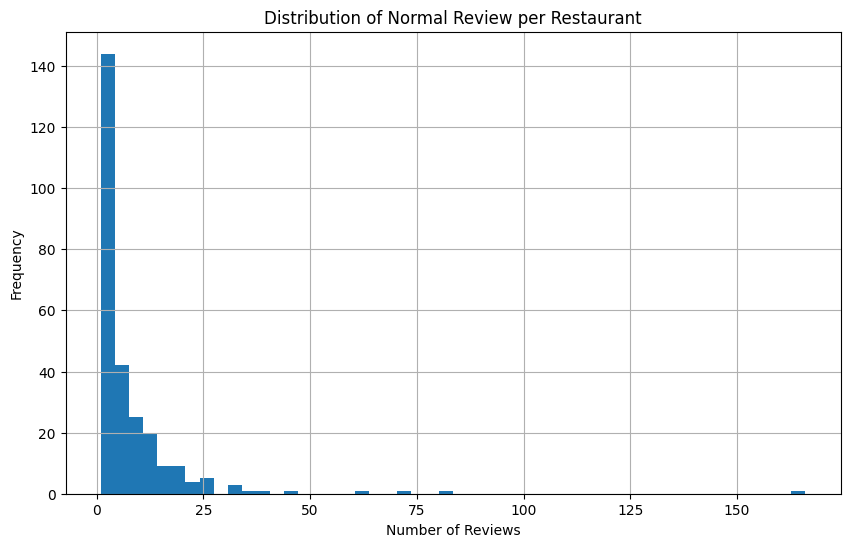

In [151]:
normal_review_counts_agg = combined_reviews.groupby('business_id')['business_id'].count()

plt.figure(figsize=(10, 6))
normal_review_counts_agg.hist(bins=50)
plt.title('Distribution of Normal Review per Restaurant')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

In [153]:
top_contributors = normal_review_counts_agg.sort_values(ascending=False).head(10)
print(top_contributors)

business_id
PP3BBaVxZLcJU54uP_wL6Q    166
6ajnOk0GcY9xbb5Ocaw8Gw     81
u7_3L1NBWgxhBM_B-cmmnA     71
sTPueJEwcRDj7ZJmG7okYA     63
lKU_kljhbEQKIPaM1Zbqiw     46
NFzfuIFghE-HnrodHpaT6A     38
sVZb87xjhbCWHQ2UXOGLrA     34
GoYSJ-YY-YwbxdgasHuq-Q     33
eJaeTZlIdM3HWCq__Ve4Wg     32
fivoAD6x6jXJRiEZwhpcEQ     31
Name: business_id, dtype: int64


In [ ]:
#The next two blocks might be wrong, I check q1 and q2 with all business and most of them habe 0 not-recommended

In [152]:
#TOTAL(!!) NUMBER OF NOT RECOMMENDED PRE CUT_OFF_DATE FOR EACH BUSINESS

#Join this with every review in the normal-review-dataset
merged_data_updated = pd.merge(normal_reviews, not_recommended_agg_pre_cutoff, on='business_id', how='left')
merged_data_updated['not_recommended_review_count_pre'] = merged_data_updated['not_recommended_review_count_pre'].fillna(0)

merged_data_updated.head()
#merged_data_updated[merged_data_updated['business_id'] == '1NCUTTp6rIyXpwUDVv9qOA']

,user_id,business_id,stars,text,date,not_recommended_review_count_pre
0,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,9.0
1,9oHOoqk-HlwDS2DlHLi_0g,TttFjRQ-8Iz8by4hsD7iOQ,5,Last night we tried to get into the oldest Ita...,2017-11-06 17:26:43,0.0
2,gSEhdaQNcewg-ob6xSgleQ,1NCUTTp6rIyXpwUDVv9qOA,2,I had to write an order after coming here a co...,2016-06-22 21:51:03,6.0
3,JW5W4OZCohTvZlRF1jzrTg,u7_3L1NBWgxhBM_B-cmmnA,4,This amazing brick oven pizza joint gets bette...,2017-04-30 15:00:27,4.0
4,7ktyPHE-NGnWxarOqjIQiQ,CinrOH8rMB2hEvPY_iFOHA,1,"I really wanted to like Casselli's, but it was...",2009-03-02 02:05:49,2.0


In [155]:
# 3. focus on q1 (bottom 25% of number of not recommended) for control group and q4 (top 25% of number of not recommended) for treatment group
unique_restaurants_df = merged_data_updated.drop_duplicates(subset='business_id', keep='first')

q1_value = unique_restaurants_df['not_recommended_review_count_pre'].quantile(0.25) #0
q4_value = unique_restaurants_df['not_recommended_review_count_pre'].quantile(0.75) #8

control_group = unique_restaurants_df[unique_restaurants_df['not_recommended_review_count_pre'] <= q1_value]
treatment_group = unique_restaurants_df[unique_restaurants_df['not_recommended_review_count_pre'] >= q4_value]

#4. how many restaurants?
control_group_count = len(control_group)
treatment_group_count = len(treatment_group)

print(f"Control Group: {control_group_count} businesses, Treatment Group: {treatment_group_count} businesses")
print(q1_value, q4_value)

Control Group: 188 businesses, Treatment Group: 140 businesses
0.0 8.0


In [ ]:
#FROM HERE ON JUST IGNORE FOR NOW

In [88]:
# DROP ALL BUSINESS THAT ARE NOT IN Q1 OR Q4.
merged_data_filtered = merged_data_updated[
    (merged_data_updated['not_recommended_review_count_pre'] <= q1_value) | 
    (merged_data_updated['not_recommended_review_count_pre'] >= q4_value)]

# Decide if control or treatment
merged_data_filtered['treatment'] = merged_data_filtered['not_recommended_review_count_pre'].apply(
    lambda x: 0 if x <= q1_value else 1)

merged_data_filtered.head()

/var/folders/_v/_hbrmw9n4qjdtrf9w3730x680000gn/T/ipykernel_67327/4121832123.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_filtered['treatment'] = merged_data_filtered['not_recommended_review_count_pre'].apply(


,user_id,business_id,stars,text,date,cut_off_date,not_recommended_review_count_pre,treatment
0,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,0,9.0,1
1,9oHOoqk-HlwDS2DlHLi_0g,TttFjRQ-8Iz8by4hsD7iOQ,5,Last night we tried to get into the oldest Ita...,2017-11-06 17:26:43,1,0.0,0
5,vqaJs9VyVLkbixSetsVKyQ,rVfe1LHo55A2fworkm_jVw,5,"Originally, our little group headed to Frankli...",2017-04-30 20:36:07,1,0.0,0
6,qz1XgXvvtRR8WKyWUXSJig,wUnLSg_GKfEIQ5CQQ770_g,5,I highly recommend this place! This was our fi...,2017-02-20 02:14:55,1,24.0,1
8,nBUnQnecIYYWuxk0g5njhw,j99PtxlKTW_u5alE4jiqHQ,5,Went here with my boyfriend and we loved it!\n...,2011-10-27 21:45:26,0,16.0,1


In [96]:
# 5. number of "normal" reviews (e.g.) 8 weeks before and 8 weeks after the change (or try 10 weeks, 12 weeks).

two_weeks = pd.Timedelta(weeks=12)

start_date = cut_off_date - two_weeks
end_date = cut_off_date + two_weeks

total_reviews_before_cutoff = merged_data_updated[(merged_data_updated['date'] >= start_date) & (merged_data_updated['date'] < cut_off_date)].shape[0]
total_reviews_after_cutoff = merged_data_updated[(merged_data_updated['date'] >= cut_off_date) & (merged_data_updated['date'] <= end_date)].shape[0]


print(f"Total reviews within two weeks before cutoff: {total_reviews_before_cutoff}, Total reviews within two weeks after cutoff: {total_reviews_after_cutoff}")


Total reviews within two weeks before cutoff: 1655, Total reviews within two weeks after cutoff: 1678


In [ ]:
#CHANGE DUMMY --> decide if before or after cut_off_date
#1. find the "change" date from "filtered" to "not recommended"


#decide if the reviews are pre or post cut_off_date (0 pre - 1 post) (Change Dummy)
normal_reviews['cut_off_date'] = (normal_reviews['date'] >= cut_off_date).astype(int)
not_recommended['cut_off_date'] = (not_recommended['review_date'] >= cut_off_date).astype(int)

normal_reviews.head(5)
#not_recommended[not_recommended['cut_off_date'] == 0]

In [10]:
#TREATMENT --> decide if they are control group or treatment group (low number not-recomended vs highnumber, MEDIAN AS THRESHOLD)

#Define the threshold to decide if treatment or control --> median of number of not recommended (?)
threshold = merged_data_updated['not_recommended_review_count_pre'].median() #THRESHOLD = 34

#Compare with threshold
merged_data_updated['control_vs_treatment'] = (merged_data_updated['not_recommended_review_count_pre'] >= threshold).astype(int)

merged_data_updated.head(5)

,user_id,business_id,stars,useful,funny,cool,text,date,cut_off_date,not_recommended_review_count_pre,not_recommended_review_count_till_date,control_vs_treatment
0,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,0,34.0,0,1
1,9oHOoqk-HlwDS2DlHLi_0g,TttFjRQ-8Iz8by4hsD7iOQ,5,0,0,0,Last night we tried to get into the oldest Ita...,2017-11-06 17:26:43,0,13.0,3,0
2,gSEhdaQNcewg-ob6xSgleQ,1NCUTTp6rIyXpwUDVv9qOA,2,0,0,0,I had to write an order after coming here a co...,2016-06-22 21:51:03,0,17.0,11,0
3,JW5W4OZCohTvZlRF1jzrTg,u7_3L1NBWgxhBM_B-cmmnA,4,0,0,0,This amazing brick oven pizza joint gets bette...,2017-04-30 15:00:27,0,41.0,29,1
4,7ktyPHE-NGnWxarOqjIQiQ,CinrOH8rMB2hEvPY_iFOHA,1,3,4,1,"I really wanted to like Casselli's, but it was...",2009-03-02 02:05:49,0,5.0,0,0


In [11]:
#ADD COLUMN FOR LENGHT OF TEXT-REVIEW
merged_data_updated['text_length'] = merged_data_updated['text'].apply(len)

merged_data_updated.head()

,user_id,business_id,stars,useful,funny,cool,text,date,cut_off_date,not_recommended_review_count_pre,not_recommended_review_count_till_date,control_vs_treatment,text_length
0,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,0,34.0,0,1,175
1,9oHOoqk-HlwDS2DlHLi_0g,TttFjRQ-8Iz8by4hsD7iOQ,5,0,0,0,Last night we tried to get into the oldest Ita...,2017-11-06 17:26:43,0,13.0,3,0,559
2,gSEhdaQNcewg-ob6xSgleQ,1NCUTTp6rIyXpwUDVv9qOA,2,0,0,0,I had to write an order after coming here a co...,2016-06-22 21:51:03,0,17.0,11,0,658
3,JW5W4OZCohTvZlRF1jzrTg,u7_3L1NBWgxhBM_B-cmmnA,4,0,0,0,This amazing brick oven pizza joint gets bette...,2017-04-30 15:00:27,0,41.0,29,1,499
4,7ktyPHE-NGnWxarOqjIQiQ,CinrOH8rMB2hEvPY_iFOHA,1,3,4,1,"I really wanted to like Casselli's, but it was...",2009-03-02 02:05:49,0,5.0,0,0,1235


In [12]:
#ADD LOGIC FOR SENTIMENTAL ANALYSIS (package is texblob, rating from -1 to 1)
#This is also slow, no idea why.

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

merged_data_updated['sentiment_score'] = merged_data_updated['text'].apply(get_sentiment)


In [13]:
merged_data_updated.head(5)




,user_id,business_id,stars,useful,funny,cool,text,date,cut_off_date,not_recommended_review_count_pre,not_recommended_review_count_till_date,control_vs_treatment,text_length,sentiment_score
0,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,0,34.0,0,1,175,0.384000
1,9oHOoqk-HlwDS2DlHLi_0g,TttFjRQ-8Iz8by4hsD7iOQ,5,0,0,0,Last night we tried to get into the oldest Ita...,2017-11-06 17:26:43,0,13.0,3,0,559,0.025000
2,gSEhdaQNcewg-ob6xSgleQ,1NCUTTp6rIyXpwUDVv9qOA,2,0,0,0,I had to write an order after coming here a co...,2016-06-22 21:51:03,0,17.0,11,0,658,-0.361012
3,JW5W4OZCohTvZlRF1jzrTg,u7_3L1NBWgxhBM_B-cmmnA,4,0,0,0,This amazing brick oven pizza joint gets bette...,2017-04-30 15:00:27,0,41.0,29,1,499,0.580000
4,7ktyPHE-NGnWxarOqjIQiQ,CinrOH8rMB2hEvPY_iFOHA,1,3,4,1,"I really wanted to like Casselli's, but it was...",2009-03-02 02:05:49,0,5.0,0,0,1235,-0.063507


In [14]:
first_five_rows = merged_data_updated.head(5)
csv_data = first_five_rows.to_csv('/Users/marcotoccoli/Desktop/Thesis/web_scraping/outcomes/first_5_rows.csv', index=False)


In [15]:
# DiD analysis with review length as the dependent variable
model_length = smf.ols('text_length ~ cut_off_date + control_vs_treatment + cut_off_date * control_vs_treatment', data=merged_data_updated).fit()
print(model_length.summary())


                            OLS Regression Results                            
Dep. Variable:            text_length   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     82.96
Date:                Tue, 23 Jan 2024   Prob (F-statistic):           1.37e-53
Time:                        10:43:23   Log-Likelihood:            -6.4211e+05
No. Observations:               82982   AIC:                         1.284e+06
Df Residuals:                   82978   BIC:                         1.284e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [2]:
#ADD TOTAL (!!) NUMBER OF REVIEWS THAT USER HAS DONE UNTILL CUT-OFF-DATE

#Take only reviews before cut_off_date
pre_cutoff_reviews = normal_reviews[normal_reviews['date'] <= cut_off_date]

#Group by users_id
user_review_counts = pre_cutoff_reviews.groupby('user_id').size().reset_index(name='total_reviews_by_user_pre_cutoff')

#Join with main dataframe
merged_data_updated = pd.merge(merged_data_updated, user_review_counts, on='user_id', how='left')


NameError: name 'normal_reviews' is not defined

In [1]:
value_counts = merged_data_updated['business_id'].value_counts(dropna=False)


NameError: name 'merged_data_updated' is not defined

In [17]:
with open('yelp_dataset/users.json', 'r') as file:
    users_data = json.load(file)

# Convert JSON data to DataFrame
users_df = pd.DataFrame(users_data)

# Perform the join
merged_data_updated = pd.merge(merged_data_updated, users_df, on='user_id', how='left') 

In [ ]:
merged_data_updated.head()

,user_id,business_id,stars,useful,funny,cool,text,date,cut_off_date,not_recommended_review_count_pre,not_recommended_review_count_till_date,control_vs_treatment,text_length,sentiment_score,total_reviews_by_user_pre_cutoff
0,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,0,34.0,0,1,175,0.384000,5.0
1,9oHOoqk-HlwDS2DlHLi_0g,TttFjRQ-8Iz8by4hsD7iOQ,5,0,0,0,Last night we tried to get into the oldest Ita...,2017-11-06 17:26:43,0,13.0,3,0,559,0.025000,2.0
2,gSEhdaQNcewg-ob6xSgleQ,1NCUTTp6rIyXpwUDVv9qOA,2,0,0,0,I had to write an order after coming here a co...,2016-06-22 21:51:03,0,17.0,11,0,658,-0.361012,2.0
3,JW5W4OZCohTvZlRF1jzrTg,u7_3L1NBWgxhBM_B-cmmnA,4,0,0,0,This amazing brick oven pizza joint gets bette...,2017-04-30 15:00:27,0,41.0,29,1,499,0.580000,31.0
4,7ktyPHE-NGnWxarOqjIQiQ,CinrOH8rMB2hEvPY_iFOHA,1,3,4,1,"I really wanted to like Casselli's, but it was...",2009-03-02 02:05:49,0,5.0,0,0,1235,-0.063507,23.0


In [ ]:


5. number of "normal" reviews (e.g.) 8 weeks before and 8 weeks after the change (or try 10 weeks, 12 weeks).



In [ ]:
#ADD NUMBER OF REVIEWS UNTIL NORMAL REVIEW WAS DONE

#Do we need it? O(n2), will most likely not run with final dataset

In [ ]:
#ADD OTHER COLUMNS HERE, REMEMBER TO CHECK BUSINESS TABLE GIVEN BY YELP

FROM NOW ONLY DIFFERENCE IN DIFFERENCE, DATA-PREPARATION SHOULD BE DONE BEFORE THIS CODE

In [ ]:
# DiD analysis with sentiment score as the dependent variable
model_sentiment = smf.ols('sentiment_score ~ period + control_vs_treatment + period * control_vs_treatment', data=merged_data_updated).fit()
print(model_sentiment.summary())

                            OLS Regression Results                            
Dep. Variable:        sentiment_score   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     109.0
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           1.98e-70
Time:                        18:27:04   Log-Likelihood:                 8491.6
No. Observations:               82982   AIC:                        -1.698e+04
Df Residuals:                   82978   BIC:                        -1.694e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [ ]:
#COUNT THE NUMBER OF NOT-RECOMMENED REVIEWS PRESENT 'TIL THE NORMAL REVIEW WAS WRITTEN
#WARNING --> I AM NOT SURE THIS WILL RUN IF THE DATASET IS TOO BIG, O(n*2) 

# Sort the data (this is actually not needed but I did it to debug)
#merged_data_updated = merged_data_updated.sort_values(by=['business_id', 'date'])
#not_recommended = not_recommended.sort_values(by=['business_id', 'review_date'])

# Initialize a column for the count
merged_data_updated['not_recommended_review_count_till_date'] = 0

# Counting process
for index, normal_review in merged_data_updated.iterrows():
    count = not_recommended[
        (not_recommended['business_id'] == normal_review['business_id']) &
        (not_recommended['review_date'] <= normal_review['date']) #maybe better to check only for daybefore? I am not 100% sure the time as an effect here.
    ].shape[0]  # Get the number of rows that match the condition

    merged_data_updated.at[index, 'not_recommended_review_count_till_date'] = count


merged_data_updated[merged_data_updated['business_id'] == 'CinrOH8rMB2hEvPY_iFOHA'].head(30)